In [22]:
import cirq
from cirq.contrib.svg import SVGCircuit
import numpy as np
from typing import *
import cirq_qubitization.cirq_infra.testing as cq_testing
from cirq_qubitization.jupyter_tools import display_gate_and_compilation, svg_circuit

# Slater Determinants 

In this notebook we will discuss preparing Slater determinants as initial states following [[1]](#ref-1), [[2]](#ref-2) and [[3]](#ref-3) for use in first-quantized quantum simulations.

A key part of many quantum algorithms is the preparation of an initial state $|\phi\rangle$ that has a reasonable overlap with a desired eigenstate, $|\psi\rangle$, of a Hamiltonian $H$. For example, in phase estimation the output is an estimate of the eigenvalue with probability $|\langle \phi | \psi\rangle|^2$, and thus preparing states with good overlap is an important task. For fermionic systems a common initial state is the Hartree-Fock state, which is defined as that Slater Determinant which minimizes the total energy of the system. The Hartree-Fock algorithm yields a set of $N$ "molecular orbitals" (MOs) $\{\phi_1(\mathbf{r})\dots\phi_N(\mathbf{r})\}$ and corresponding single-particle eigenvalues ${\epsilon_{p}}$. A Slater-Determinant is then typically formed using the $\eta$ lowest energy molecular orbitals as: 

$$
\Psi({\mathbf{r}_1\cdots\mathbf{r}_\eta}) = \frac{1}{\sqrt{N}!}\det 
    \left(
        \begin{matrix}
        \phi_1(\mathbf{\mathbf{r}_1}) & \dots & \phi_\eta(\mathbf{r}_\eta) \\
        \vdots & \dots & \vdots \\
        \phi_1(\mathbf{\mathbf{r}_\eta}) & \dots & \phi_\eta(\mathbf{r}_\eta) \\
        \end{matrix}
    \right).
$$
For example, if $\eta=2$ we have $\Psi(\mathbf{r}_1, \mathbf{r}_2) = \frac{1}{\sqrt{2}} (\phi_1(\mathbf{r_1})\phi_2(\mathbf{r}_2) - \phi_1(\mathbf{r}_2)\phi_2(\mathbf{r}_1))$. Slater determinants ensure that the many-electron state is antisymmetric under exchange of any pair of electrons $(\Psi(\mathbf{r}_1,\mathbf{r}_2) = - \Psi(\mathbf{r}_2, \mathbf{r}_1))$, which is necessary as electrons are fermions. 

Normally in chemistry and physics we write Slater determinants with the shorthand $|\Psi\rangle = |\phi_1\cdots\phi_\eta\rangle$ and typically also work in second quantization. In second quantization we only need to know which single particle orbitals are occupied, and thus the Hartree-Fock state can be written as $|\underbrace{1\cdots 1}_{\eta}\underbrace{0\cdots0}_{N-\eta}\rangle$, which signifies that the first $\eta$ MOs are occupied. Fermion statistics are then encoded through the creation and annihilation operators which satisfy $\{a_p^\dagger, a_q\} = \delta_{pq}$. The ground state of our Hamiltonian $H$ can then be expanded as a linear combination of all possible Slater determinants which can be formed by occupying $\eta$ electrons in $N$ spin-orbitals, of which there are $ N \choose \eta$ in general.

The preparation of the Hartree-Fock state in second quantization is trivial if the Hamiltonian is represented in the MO basis, one just needs to set the first $\eta$ qubits to on. However, for first quantized algorithms the task is more involved.

In first quantization, antisymmetrization has to be incorporated explicitly in our state, i.e., we form our Slater determinant through

$$
|\phi_1\dots\phi_\eta\rangle  \rightarrow \sum_{\sigma \in S_\eta} (-1)^{\pi(\sigma)}|\phi_{\sigma(i)}\dots\phi_{\sigma(\eta)}\rangle,
$$
where $\sigma$ represents a permutation of the electron labels and $\pi(\sigma)$ is the parity of the permutation. Assuming our labels are initially sorted then $\pi(\sigma) = 0$ for even permutations and $\pi(\sigma) = 1$ for an odd permutation. Also note the abuse of the ket notation to represent both product states $|\phi_{\sigma(i)}\dots\phi_{\sigma(\eta)}\rangle$ and Slater determinants $|\phi_1\dots\phi_\eta\rangle$. Note in some texts a distinction is drawn by writing product states as $|\phi_1\dots \phi_\eta)$, but we won't make that distinction here. It should be obvious from the context which we are referring to.

In the above each $\phi_p$ is associated with a basis function, and each orbital is represented using a register of size $\log N$. It is also possible to use grid based approaches but we won't discuss that here.
A convenient basis to use is a basis of $N$ planewaves:

$$
\phi_p(\mathbf{r}) = \langle \mathbf{r}|\phi_p\rangle = \frac{1}{\sqrt{\Omega}} e^{i\mathbf{k}_p\cdot\mathbf{r}}
$$
where
$$
\mathbf{k}_p = \frac{2\pi \mathbf{p}}{\Omega^{1/3}}; \quad p_{x,y,z} \in \left[-\frac{N^{1/3}-1}{2}, \frac{N^{1/3}-1}{2}\right] 
$$
and $\Omega$ is the volume of a cubic cell.

If the Hamiltonian is written in the MO basis then state preparation is straightforward in either representation as we just need to occupy specific orbitals to produce an ordered list of registers. In first quantization representation we then need to antisymmetrize this set of registers given the algorithm in [[1]](#ref-1). Unfortunately, for most systems of interest the Hamiltonian is not expressed in the MO basis (e.g. it might be written in terms of planewaves) and thus we need to prepare a generic state
$$
|\phi\rangle = \prod_{p}^{\eta} \tilde{a}_{p}|0\rangle
$$
where
$$
\tilde{a}_{p}^{\dagger} = \sum_{q} u_{pq} a_q^{\dagger}
$$
are spin orbital creation operators in our desired 'rotated' basis, with $u_{pq}$ being a basis rotation matrix (e.g. this might the MO coefficient matrix mapping atomic-orbitals to molecular orbitals, or for plane-wave density functional theory these might be mapping from planewaves to the Kohn-Sham states.)
Preparing such a state can be achieved efficiently using the Given's rotation protocol of Ref. [[4]](#ref-4), with implentations provided by [OpenFermion](https://quantumai.google/reference/python/openfermion/linalg/givens_rotations).

To start the tutorial we follow [[3]](#ref-3) and first assume we have a second quantized representation of the Slater Determinant (ignoring the complexity of Givens rotation), and try to answer how we use this representation to "copy" the information into our first quantized registers.

First let's look at the circuit in all its glory:

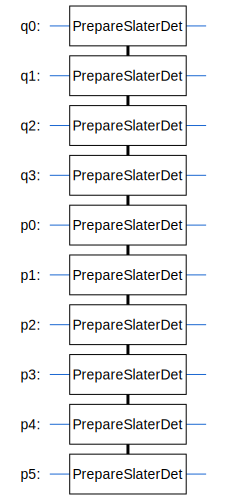

In [27]:
from cirq_qubitization.cirq_algos.initial_states.slater_determinant import SlaterDeterminant 

eta = 3
N = 4
g = cq_testing.GateHelper(SlaterDeterminant(eta, N))
svg_circuit(g.circuit, registers=g.r)



## Mapping Second Quantization to First Quantization

To begin we assume we have $N$ second quantized registers (labelled `q`), and $\eta \log N$ first quantized registers. We will only describe the more efficient implmentation in [[3]](#ref-3) which has a Toffoli complexity of 
$$
N ( 3\eta + n_\eta - 2),
$$
where $n_\eta = \lceil\log(\eta + 1)\rceil$.
The basic idea is to iterate over the $N$ second quantized registers and copy the orbital index $p$ into register $\xi$ of the first quantized registers where $\xi$ is a running count of the number of electrons found so far in the iteration. This can be achieved using a combination of unary iteration, addition gates and many CX gates for classically copying the data.

To proceed we define a register $|\xi\rangle$ of size $n_\eta$ which keeps a running count of the number of electrons, a control register $|\mathrm{ctrl}\rangle$ of size $\eta$ which will correspond to the value of $\xi$ in one-hot unary, and an ancilla $|\mathrm{anc}\rangle$ register of size $\log N$.


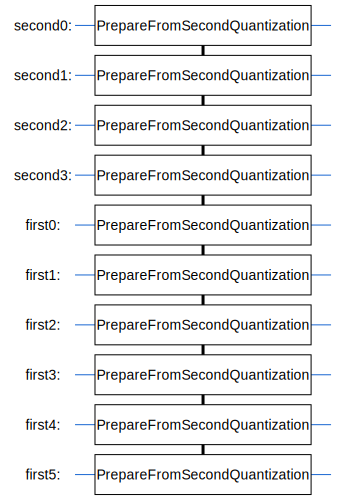

In [21]:
from cirq_qubitization.cirq_algos.initial_states.slater_determinant import FromSecondQuantization

eta = 3
N = 4
g = cq_testing.GateHelper(FromSecondQuantization(eta, N))
svg_circuit(g.circuit, registers=g.r)

## Algorithm for Antisymmetrization

Following [[1]](#ref-1) we can generate the state in 4 steps assuming the state $|\phi_i \dots \phi_\eta\rangle$ is available. Ref. [[3]](#ref-3) addresses how to prepare this initial product state in the first place.

1. Prepare ancillary register `seed` in an even superposition of all length $\eta$ strings of numbers $0,\dots,f(\eta)$ where $f(\eta) \ge \eta^2$.  
2. Sort `seed` using a reversible sorting network.
3. Delete collisions, i.e., remove strings where orbitals are multiply occupied which are forbidden by Pauli exclusion principle.
4. Apply reverse sort to `target` register.

After step 4. we have an evenly weighted superposition of all possible permutations of the original labels. Controlled phase gates are applied after each swap to ensure the correct phase. This algorithm costs $\mathcal{O} (\eta \log \eta \log N)$ $T$ gates. 

A circuit for this operation is given below:

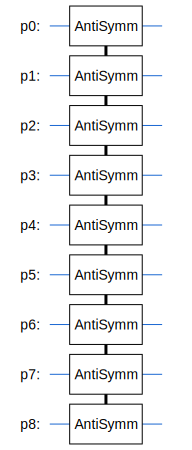

In [25]:
from cirq_qubitization.cirq_algos.initial_states.slater_determinant import AntiSymmetrize

eta = 3
N = 4
bitsize = int(np.ceil(np.log2(N) + 1))
g = cq_testing.GateHelper(AntiSymmetrize(eta, bitsize))
svg_circuit(g.circuit, registers=g.r)

## Including Givens Rotations
...


## References
<a id="ref-1" /> [1] [Improved techniques for preparing eigenstates of fermionic Hamiltonians](https://www.nature.com/articles/s41534-018-0071-5)

<a id="ref-2" /> [2] [Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040332)

<a id="ref-3" /> [3] [Quantum simulation of exact electron dynamics can be
more efficient than classical mean-field methods](https://arxiv.org/pdf/2301.01203.pdf)

<a id="ref-4" /> [4] [Quantum Simulation of Electronic Structure with Linear Depth and Connectivity](https://arxiv.org/abs/1711.04789)